In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import os
import time
import warnings

from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from matplotlib import pyplot as plt
from dotenv import load_dotenv

load_dotenv()
sns.color_palette('colorblind')
plt.style.use('Solarize_Light2')

# Setting default DPI, pulling it from dotenv if it exists, setting it on 100 if not

try:
    pc_dpi = int(os.getenv('DPI'))
except TypeError:
    pc_dpi = 100
if pc_dpi is None:
    pc_dpi = 100


tf.get_logger().setLevel("ERROR")


# 0 : Very similar approach to what we did with BERT, lots of repetitions but notebooks are separated for readability

# 1 : Loading the data
- checking and renaming for readability
- encoding categories with LabelEncode

In [2]:
data_path = "../data/ecommerce_cleaned_tf.csv"

df_model = pd.read_csv(filepath_or_buffer=data_path)

In [3]:
df_model.head(n=2)


,first_category,desc
0,home furnishing,key elegance polyester multicolor abstract eye...
1,baby care,sathiyas cotton bath towel bath towel red yell...


In [4]:
df_model.rename(columns={"first_category": "category"}, inplace=True)

le = LabelEncoder()

df_model["enc_category"] = le.fit_transform(df_model["category"])


# 2 : Building the model :
- Two possible approaches for USE : using USE from tf_text or loading it from hub, unsure if tf_text's version is the latest so loading from hub
- 20% dropout layer to avoid overfitting.
- Dense classifier layer with softmax as it suits better the multiclass problematic.
- Adjusting classifier Dense layer to len(unique_categories) (7) to match the number of categories of the dataset.
- using OHE for categories so that the output shape matches y_train/y_test shapes.


In [5]:
use_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
local_bypass = "../heavy/universal-sentence-encoder_4/"  # downloaded the model locally
use_encoder = hub.KerasLayer(local_bypass)


2023-01-03 15:08:31.677170: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [6]:
unique_categories = df_model["enc_category"].unique()


In [7]:
input_text = tf.keras.Input(shape=(), dtype=tf.string, name="text")
use_encoded_text = use_encoder(input_text)

# Neural net :
layer = tf.keras.layers.Dense(512, activation="relu")(use_encoded_text)
layer = tf.keras.layers.Dropout(rate=0.2)(layer)
layer = tf.keras.layers.Dense(512, activation="relu")(layer)
layer = tf.keras.layers.Dropout(rate=0.2)(layer)

# Output layer :
output = tf.keras.layers.Dense(len(unique_categories), activation="softmax")(layer)

# Building with inputs and outputs
model = tf.keras.Model(inputs=[input_text], outputs=[output])


In [8]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None,)]                 0         
                                                                 
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 7)                 3591  

In [9]:
model.compile(
    optimizer="adam",  # AdamW ?
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


# 3 : Training USE model
- Lighter model can run on a CPU
- 50 Epochs

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    df_model["desc"],
    df_model["enc_category"],
    test_size=0.3,
    random_state=123
)

# One-hot encode the training labels
y_train_ohe = to_categorical(y_train, num_classes=len(unique_categories))
y_test_ohe = to_categorical(y_test, num_classes=len(unique_categories))


In [11]:
history = model.fit(
    X_train,
    y_train_ohe,
    epochs=50,
    verbose=True,
)


Epoch 1/50
23/23 [==============================] - 1s 7ms/step - loss: 1.5016 - accuracy: 0.6089
Epoch 2/50
23/23 [==============================] - 0s 7ms/step - loss: 0.4781 - accuracy: 0.8827
Epoch 3/50
23/23 [==============================] - 0s 7ms/step - loss: 0.2192 - accuracy: 0.9204
Epoch 4/50
23/23 [==============================] - 0s 7ms/step - loss: 0.1403 - accuracy: 0.9553
Epoch 5/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0925 - accuracy: 0.9763
Epoch 6/50
23/23 [==============================] - 0s 8ms/step - loss: 0.0677 - accuracy: 0.9818
Epoch 7/50
23/23 [==============================] - 0s 8ms/step - loss: 0.0526 - accuracy: 0.9874
Epoch 8/50
23/23 [==============================] - 0s 8ms/step - loss: 0.0296 - accuracy: 0.9944
Epoch 9/50
23/23 [==============================] - 0s 8ms/step - loss: 0.0222 - accuracy: 0.9972
Epoch 10/50
23/23 [==============================] - 0s 8ms/step - loss: 0.0158 - accuracy: 0.9986
Epoch 11/50
23/23 [

In [12]:
model.evaluate(x=X_test, y=y_test_ohe)


10/10 [==============================] - 0s 5ms/step - loss: 0.3414 - accuracy: 0.9286


[0.34142500162124634, 0.9285714030265808]

### Observation :

- This model seems to be by far the most accurate amongst the other models studied
- Using classification report and confusion matrix to double check

# 4 : Using the classifier on test data
- Predicting on X_test
- Using numpy's argmax function to get the highest value from expected one hot encoded array of probabilities


In [13]:
y_predict_ohe = model.predict(X_test)

y_predict = np.argmax(y_predict_ohe, axis=1)


10/10 [==============================] - 0s 5ms/step


In [14]:
use_accuracy = accuracy_score(y_true=y_test, y_pred=y_predict)

print(use_accuracy)


0.9285714285714286


In [15]:
inv_y_predict = le.inverse_transform(y_predict)
inv_true = le.inverse_transform(y_test)

# This reverses the encoding on labels


In [16]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    print(classification_report(y_true=inv_true, y_pred=inv_y_predict))


                                 precision    recall  f1-score   support

                      baby care       0.78      0.82      0.80        34
beauty & personal care & health       0.94      0.93      0.94        55
     home decor & festive needs       0.88      0.96      0.91        45
                home furnishing       0.87      0.89      0.88        37
               kitchen & dining       1.00      0.92      0.96        50
                     multimedia       1.00      0.96      0.98        47
                        watches       1.00      1.00      1.00        40

                       accuracy                           0.93       308
                      macro avg       0.92      0.93      0.92       308
                   weighted avg       0.93      0.93      0.93       308



### Observation :

&emsp;Based on this classification report, it seems the model is performing extremely good in most cases. Precision, recall and F1 are at 0.92 overall. It seems the model struggles to correctly identify the items in "baby care" and "home furnishing", but the results in these categories are still high (around 80% on all metrics).

In [17]:
# Confusion matrix :

conf_matrix = pd.DataFrame(confusion_matrix(y_true=inv_true, y_pred=inv_y_predict))
conf_matrix.columns = le.inverse_transform(conf_matrix.columns)
conf_matrix.index = le.inverse_transform(conf_matrix.index)


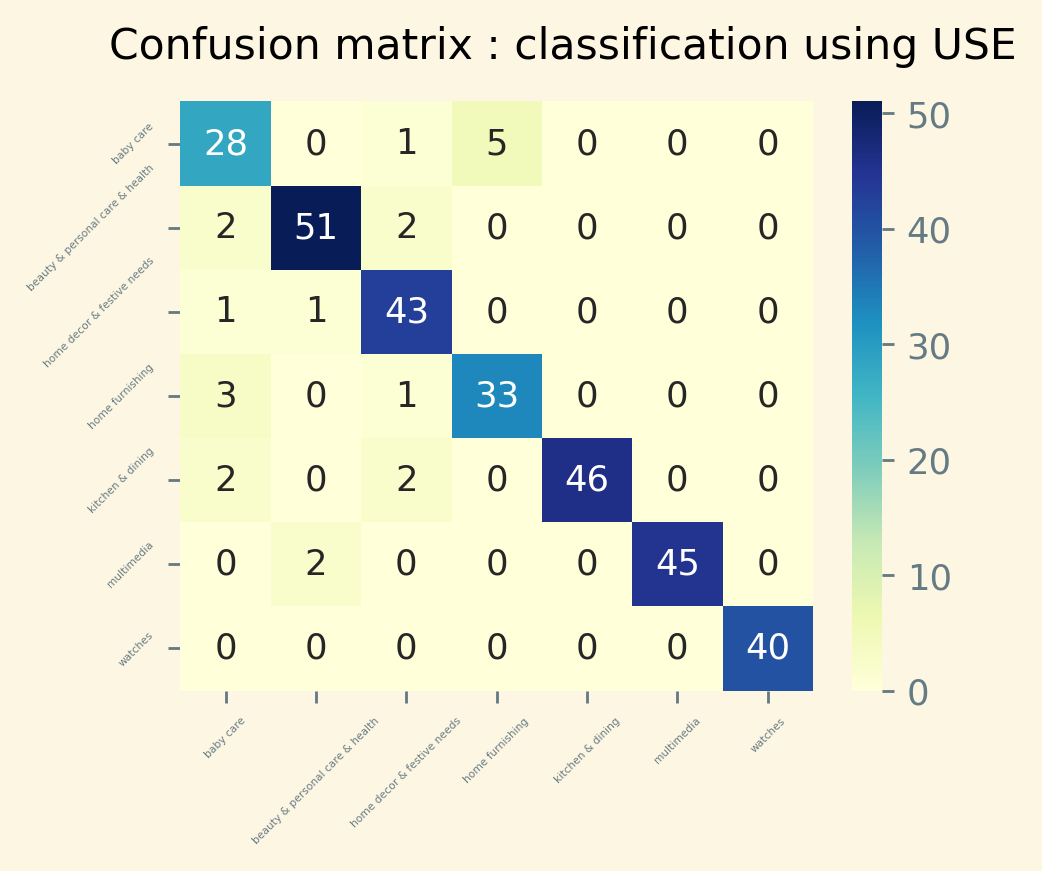

In [18]:
fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(4, 3),
    dpi=pc_dpi,
)

sns.heatmap(conf_matrix, annot=True, cmap="YlGnBu", xticklabels=True, yticklabels=True)

###
# Titles/Lables
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tick_params(labelsize=3)
fig.suptitle("Confusion matrix : classification using USE")
#
###

plt.show()


# Conclusion :

- While it can be perfected, with potentially a larger sample of data, this algorithm seems to be the most promising to upscale :
- It is highly accurate and fast to train
- It will benefit from an application on a larger database while not suffering from the potential issues of the sparse methods (BOW / TF-IDF)
- A larger sample might provide enough information on why "baby care" and "home furnishing" are often the least correctly identified classes but, in this case, it is still quite accurate 